#############
### 0. 데이터 증가(2012.05.20~ 2025.05.20)
### 1. 트럼프 관세(비트코인영향)
### 2. dropout(정규화), early stoping  -> 과적합방지
### 3. learning late ==> 하이퍼파라미터
### 4. 함수로 묶기

# 1. GRU 모델을 사용하여 비트코인 예측하는 프로그램

##  1- 1. 데이터 불러오기 ( 2018년~ 2022년 데이터 학습 한후 2023년 예측)


In [1]:
!pip install finance-datareader # FinanceDataReader에서 데이터를 불러오기 위해 FinanceDataReader를 설치하는 과정

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.4 MB/s eta 0:00:00


In [44]:
##### 추가연구 없이 2018.01.01~ 2022.12.31일 데이터 사용 ,
#### 나스닥 지수 + 환율데이터 + 코인데이터 를 활용하여 종가 예측하기
#### 추가로  뉴스 및 소셜 미디어 감성 분석을 하여 긍정인 뉴스는 1로, 부정인 뉴스는 0으로 라벨링 하여 진행하기
############# 이코드 사용하기
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU,Dropout
from sklearn.metrics import r2_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 데이터 불러오기
start_date = "2018-01-01" # "2018-01-01"
end_date = "2023-03-01"  #23.03.01  ,   "2022-12-31" 2025-08-20
ticker = "BTC/KRW"  # 한국거래소에서 비트코인을 가격 데이터 가져오기
df = pd.DataFrame(fdr.DataReader(ticker, start_date, end_date))

In [11]:
## 비트코인 데이터
df

,Open,High,Low,Close,Volume,Adj Close
2018-01-01,15047133.0,15046287.0,14026068.0,14548333.0,10962700800000,14548333.0
2018-01-02,14514031.0,16400157.0,13990142.0,15918331.0,17899344238000,15918331.0
2018-01-03,15914188.0,16565566.0,15788165.0,16172952.0,17950689456200,16172952.0
2018-01-04,16247109.0,16707220.0,15433904.0,16552935.0,23115024576400,16552935.0
2018-01-05,16423476.0,18802922.0,16131843.0,18510128.0,25319034814500,18510128.0
...,...,...,...,...,...,...
2023-02-25,30503590.0,30516850.0,30058378.0,30470984.0,21169228713656,30470984.0
2023-02-26,30469374.0,31100762.0,30351134.0,30978638.0,21884484860535,30978638.0
2023-02-27,30978950.0,31444266.0,30541950.0,31019684.0,29882818252455,31019684.0
2023-02-28,31018320.0,31092330.0,30533116.0,30600802.0,27147750459806,30600802.0


## 1-2. 데이터 전처리

In [45]:
# 6개의 열 학습
# 데이터 전처리
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.iloc[:,3:4]) # minmaxScaler는 스케일을 조정하는 정규화 함수로, 모든 데이터가 0과 1사이의 값을 갖도록 해주는 함수이다
                          # 따라서 최댓값은 1로, 최솟값은 0으로 데이터의 범위를 조정해준다. 객체생성함

In [ ]:
scaled_data.shape # (2, 6)

(2789, 1)

In [46]:
# train, test 데이터 생성

train_size = int(len(scaled_data) * 0.7)   ## 전체 데이터셋 중 70%를 학습 데이터셋으로, 20%를 테스트 데이터셋(검증용) 으로 사용하기 위해서 0.8을 곱했다
                                          # 모델 학습 시 과적합을 방지하고 일반화 성능을 높이기 위해 사용된다
train_data = scaled_data[:train_size] # 1789
test_data = scaled_data[train_size:] # 768

def create_dataset(data, look_back): #look_back은 몇 개의 과거 데이터를 사용할 것인지를 표현하는 것이다(기본값이 60이다)
    x, y = [], []        #  for문에서 얻은 모든 입력 데이터(x)와 출력 데이터(y)를 리스트에 추가한다
    for i in range(len(data)-look_back):  # train : 1759까지 , test: 738까지
        x.append(data[i:(i+look_back), :])   # i부터 (i+look_back)까지의 데이터를 하나의 입력 데이터 x 로 표현한다, 종가와 저가사용
        y.append([data[i+look_back, :]])       # i+look_back의 데이터를 출력 데이터 y 로 표현한다.
    return np.array(x), np.array(y)         # 리스트를 numpy 배열로 변환하여 반환

# create_dataset()는 시계열 데이터를 RNN 모델에 입력으로 사용하기 위해 입력 데이터와 출력 데이터로 분리하는 함수이다.

look_back = 60
x_train, y_train = create_dataset(train_data, look_back)
x_test, y_test = create_dataset(test_data, look_back)

In [5]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape
# x_train.shpae : (샘플수, look_back, 특성개수)
# y_train.shape : (샘플수, 예측 한날의 정답, 특성개수)
# x_test.shape :  (샘플수 , look_back, 특성개수)
# y_test.shape :  (샘플수, 예측 한날의 정답, 특성개수)

((1218, 60, 1), (1218, 1, 1), (488, 60, 1), (488, 1, 1))

## 1-3. GRU 모델 생성

In [47]:
# 모델 생성
es = EarlyStopping(monitor= 'val_loss', mode='min', verbose=1, patience=5)
  # 검증손실이 5번연속 줄지않으면 학습중단 , verbose=1 :자세히출력, 0;출력x , 2:함축적인정보만 출력

mc= ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1,save_best_only=True)
  # 검증손실이 가장 작을때의 모델만 저장
model = Sequential()   # 모델의 객체생성
model.add(GRU(150, input_shape=(look_back, 1)))   #  50=레이어의 출력 차원, input_shape=입력 데이터의 형태를 정의를 의미한다.
                                                  # lock_back=이전 데이터의 갯수만큼 비트코인 가격을 입력으로 받아들이고, 각각의 데이터가 1차원인 것을 의미합니다.
model.add(Dropout(0.2))
model.add(Dense(1))   # Dense 는 완전 연결 레이어(층)를 의미한다. 1은 출력의 차원을 의미

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae'] )  # compile() 함수를 이용하여 모델을 컴파일합니다
                                                             # loss는 손실 함수를 의미한다.
                                                             # mean_squared_error(MSE) 는 전체 에러를 표현하기 위해서 사용하는 식이고 오차의 제곱에 대해 평균을 취한 것이다.(수치가 작을 수록 원본과의 오차가 적은 것이다)
                                                             # optimizer는  최적화 알고리즘을 정의하는 부분이다. adam(아담) 은 모멘텀+ AdaGrad(아다그라드) 을 합친 것이다

# 완전 연결 레이어 : 한 레이어의 모든 뉴런이 그 다음 레이어의 모든 뉴런과 연결된 상태이다.
# 모멘텀 : 기울기 방향으로 힘을 받아 물체가 가속된다는 물리법칙을 적용한것이다.
# AdaGrad : 학습을 진행하면서 학습률을 점차 줄여가는 방법이다.
# dropout 하기전 7분 실행됨

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## 1-4. GRU 모델 학습

In [48]:
# 모델 학습
model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test),callbacks=[es,mc], batch_size=32, validation_split=0.1, verbose=2)

# x_train : 학습데이터의 입력값   , y_train : 학습데이터의 출력값이다.

# 에포크 : 훈련 데이터셋에 포함된 모든 데이터들이 한 번씩 모델을 통과한 횟수 또는 전체 학습 데이터셋에 대한 반복 횟수이다
# 에포크가 높을수록 더 많은 반복 학습을 수행하게 되므로 모델이 더 많은 학습을 하게 되어 일반적으로 더 좋은 성능을 낼 수 있습니다

# batch_size(배치크기) : 학습을 수행할 때, 몇 개의 데이터를 한 번에 처리할지를 지정한다, 일반적으로 32,64, 128 숫자를 사용한다

# verbose : 학습 과정 중 출력되는 문구를 설정합니다. 0일 경우 출력하지 않으며, 1일 경우 학습 진행 상황을 출력하고, 2일 경우 학습 결과만 출력한다

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.00060, saving model to best_model.h5


40/40 - 6s - 149ms/step - loss: 0.0060 - mae: 0.0439 - mse: 0.0060 - val_loss: 6.0185e-04 - val_mae: 0.0167 - val_mse: 6.0185e-04
Epoch 2/100

Epoch 2: val_loss did not improve from 0.00060
40/40 - 5s - 116ms/step - loss: 6.6410e-04 - mae: 0.0143 - mse: 6.6410e-04 - val_loss: 6.2842e-04 - val_mae: 0.0171 - val_mse: 6.2842e-04
Epoch 3/100

Epoch 3: val_loss improved from 0.00060 to 0.00060, saving model to best_model.h5


40/40 - 3s - 86ms/step - loss: 6.0539e-04 - mae: 0.0133 - mse: 6.0539e-04 - val_loss: 5.9901e-04 - val_mae: 0.0172 - val_mse: 5.9901e-04
Epoch 4/100

Epoch 4: val_loss did not improve from 0.00060
40/40 - 5s - 134ms/step - loss: 6.1479e-04 - mae: 0.0135 - mse: 6.1479e-04 - val_loss: 6.9219e-04 - val_mae: 0.0195 - val_mse: 6.9219e-04
Epoch 5/100

Epoch 5: val_loss did not improve from 0.00060
40/40 - 5s - 137ms/step - loss: 5.5706e-04 - mae: 0.0131 - mse: 5.5706e-04 - val_loss: 6.5398e-04 - val_mae: 0.0179 - val_mse: 6.5398e-04
Epoch 6/100

Epoch 6: val_loss improved from 0.00060 to 0.00048, saving model to best_model.h5


40/40 - 5s - 119ms/step - loss: 5.7577e-04 - mae: 0.0135 - mse: 5.7577e-04 - val_loss: 4.8340e-04 - val_mae: 0.0153 - val_mse: 4.8340e-04
Epoch 7/100

Epoch 7: val_loss improved from 0.00048 to 0.00047, saving model to best_model.h5


40/40 - 6s - 157ms/step - loss: 4.6176e-04 - mae: 0.0121 - mse: 4.6176e-04 - val_loss: 4.7143e-04 - val_mae: 0.0150 - val_mse: 4.7143e-04
Epoch 8/100

Epoch 8: val_loss did not improve from 0.00047
40/40 - 4s - 92ms/step - loss: 4.6224e-04 - mae: 0.0125 - mse: 4.6224e-04 - val_loss: 0.0010 - val_mae: 0.0249 - val_mse: 0.0010
Epoch 9/100

Epoch 9: val_loss did not improve from 0.00047
40/40 - 5s - 128ms/step - loss: 5.2673e-04 - mae: 0.0132 - mse: 5.2673e-04 - val_loss: 4.8532e-04 - val_mae: 0.0152 - val_mse: 4.8532e-04
Epoch 10/100

Epoch 10: val_loss improved from 0.00047 to 0.00047, saving model to best_model.h5


40/40 - 5s - 129ms/step - loss: 3.9946e-04 - mae: 0.0114 - mse: 3.9946e-04 - val_loss: 4.6758e-04 - val_mae: 0.0149 - val_mse: 4.6758e-04
Epoch 11/100

Epoch 11: val_loss improved from 0.00047 to 0.00045, saving model to best_model.h5


40/40 - 5s - 120ms/step - loss: 4.7562e-04 - mae: 0.0126 - mse: 4.7562e-04 - val_loss: 4.4789e-04 - val_mae: 0.0146 - val_mse: 4.4789e-04
Epoch 12/100

Epoch 12: val_loss improved from 0.00045 to 0.00044, saving model to best_model.h5


40/40 - 5s - 125ms/step - loss: 4.3908e-04 - mae: 0.0118 - mse: 4.3908e-04 - val_loss: 4.4125e-04 - val_mae: 0.0144 - val_mse: 4.4125e-04
Epoch 13/100

Epoch 13: val_loss did not improve from 0.00044
40/40 - 4s - 90ms/step - loss: 4.6649e-04 - mae: 0.0134 - mse: 4.6649e-04 - val_loss: 6.8755e-04 - val_mae: 0.0197 - val_mse: 6.8755e-04
Epoch 14/100

Epoch 14: val_loss improved from 0.00044 to 0.00043, saving model to best_model.h5


40/40 - 5s - 124ms/step - loss: 3.6786e-04 - mae: 0.0109 - mse: 3.6786e-04 - val_loss: 4.3319e-04 - val_mae: 0.0143 - val_mse: 4.3319e-04
Epoch 15/100

Epoch 15: val_loss improved from 0.00043 to 0.00042, saving model to best_model.h5


40/40 - 6s - 140ms/step - loss: 4.1007e-04 - mae: 0.0116 - mse: 4.1007e-04 - val_loss: 4.1871e-04 - val_mae: 0.0141 - val_mse: 4.1871e-04
Epoch 16/100

Epoch 16: val_loss did not improve from 0.00042
40/40 - 5s - 117ms/step - loss: 3.9915e-04 - mae: 0.0114 - mse: 3.9915e-04 - val_loss: 9.0547e-04 - val_mae: 0.0239 - val_mse: 9.0547e-04
Epoch 17/100

Epoch 17: val_loss did not improve from 0.00042
40/40 - 7s - 170ms/step - loss: 4.6303e-04 - mae: 0.0123 - mse: 4.6303e-04 - val_loss: 5.6670e-04 - val_mae: 0.0168 - val_mse: 5.6670e-04
Epoch 18/100

Epoch 18: val_loss improved from 0.00042 to 0.00040, saving model to best_model.h5


40/40 - 9s - 218ms/step - loss: 3.6367e-04 - mae: 0.0110 - mse: 3.6367e-04 - val_loss: 4.0069e-04 - val_mae: 0.0137 - val_mse: 4.0069e-04
Epoch 19/100

Epoch 19: val_loss did not improve from 0.00040
40/40 - 5s - 119ms/step - loss: 3.5396e-04 - mae: 0.0109 - mse: 3.5396e-04 - val_loss: 7.6135e-04 - val_mae: 0.0217 - val_mse: 7.6135e-04
Epoch 20/100

Epoch 20: val_loss did not improve from 0.00040
40/40 - 4s - 94ms/step - loss: 4.2720e-04 - mae: 0.0124 - mse: 4.2720e-04 - val_loss: 4.4844e-04 - val_mae: 0.0153 - val_mse: 4.4844e-04
Epoch 21/100

Epoch 21: val_loss did not improve from 0.00040
40/40 - 3s - 79ms/step - loss: 3.7159e-04 - mae: 0.0109 - mse: 3.7159e-04 - val_loss: 4.2696e-04 - val_mae: 0.0143 - val_mse: 4.2696e-04
Epoch 22/100

Epoch 22: val_loss improved from 0.00040 to 0.00040, saving model to best_model.h5


40/40 - 6s - 144ms/step - loss: 4.4122e-04 - mae: 0.0130 - mse: 4.4122e-04 - val_loss: 3.9771e-04 - val_mae: 0.0137 - val_mse: 3.9771e-04
Epoch 23/100

Epoch 23: val_loss did not improve from 0.00040
40/40 - 4s - 90ms/step - loss: 3.5039e-04 - mae: 0.0101 - mse: 3.5039e-04 - val_loss: 4.8087e-04 - val_mae: 0.0150 - val_mse: 4.8087e-04
Epoch 24/100

Epoch 24: val_loss did not improve from 0.00040
40/40 - 3s - 83ms/step - loss: 3.9671e-04 - mae: 0.0123 - mse: 3.9671e-04 - val_loss: 9.6947e-04 - val_mae: 0.0246 - val_mse: 9.6947e-04
Epoch 25/100

Epoch 25: val_loss did not improve from 0.00040
40/40 - 5s - 124ms/step - loss: 3.5846e-04 - mae: 0.0113 - mse: 3.5846e-04 - val_loss: 4.2149e-04 - val_mae: 0.0143 - val_mse: 4.2149e-04
Epoch 26/100

Epoch 26: val_loss did not improve from 0.00040
40/40 - 5s - 133ms/step - loss: 3.9047e-04 - mae: 0.0113 - mse: 3.9047e-04 - val_loss: 6.0193e-04 - val_mae: 0.0185 - val_mse: 6.0193e-04
Epoch 27/100

Epoch 27: val_loss improved from 0.00040 to 0.0003

40/40 - 6s - 151ms/step - loss: 4.0349e-04 - mae: 0.0120 - mse: 4.0349e-04 - val_loss: 3.8524e-04 - val_mae: 0.0136 - val_mse: 3.8524e-04
Epoch 28/100

Epoch 28: val_loss improved from 0.00039 to 0.00037, saving model to best_model.h5


40/40 - 4s - 104ms/step - loss: 4.4476e-04 - mae: 0.0129 - mse: 4.4476e-04 - val_loss: 3.6910e-04 - val_mae: 0.0128 - val_mse: 3.6910e-04
Epoch 29/100

Epoch 29: val_loss did not improve from 0.00037
40/40 - 6s - 158ms/step - loss: 3.1701e-04 - mae: 0.0106 - mse: 3.1701e-04 - val_loss: 3.8388e-04 - val_mae: 0.0131 - val_mse: 3.8388e-04
Epoch 30/100

Epoch 30: val_loss did not improve from 0.00037
40/40 - 4s - 96ms/step - loss: 3.1934e-04 - mae: 0.0102 - mse: 3.1934e-04 - val_loss: 5.5515e-04 - val_mae: 0.0175 - val_mse: 5.5515e-04
Epoch 31/100

Epoch 31: val_loss did not improve from 0.00037
40/40 - 3s - 79ms/step - loss: 3.7881e-04 - mae: 0.0107 - mse: 3.7881e-04 - val_loss: 4.3909e-04 - val_mae: 0.0153 - val_mse: 4.3909e-04
Epoch 32/100

Epoch 32: val_loss did not improve from 0.00037
40/40 - 4s - 105ms/step - loss: 3.4420e-04 - mae: 0.0102 - mse: 3.4420e-04 - val_loss: 5.9801e-04 - val_mae: 0.0184 - val_mse: 5.9801e-04
Epoch 33/100

Epoch 33: val_loss did not improve from 0.00037
40

## 1-5. 예측

In [38]:
# 예측
train_predict = model.predict(x_train)  # (1759, 6)
test_predict = model.predict(x_test) #  (738, 6)

# model.predict(x_train) 은 학습된 모델을 이용하여 train 데이터에 대한 예측값을 계산한다
# mode.predict(x_test) 은 학습된 모델을 이용하여 test 데이터에 대한 예측값을 계산한다.

train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1,1))
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [ ]:
train_predict.shape, y_train.shape, test_predict.shape, y_test.shape

((1892, 1), (1892, 1), (777, 1), (777, 1))

## 1-6. 모델 시각화
### https://wikidocs.net/92088

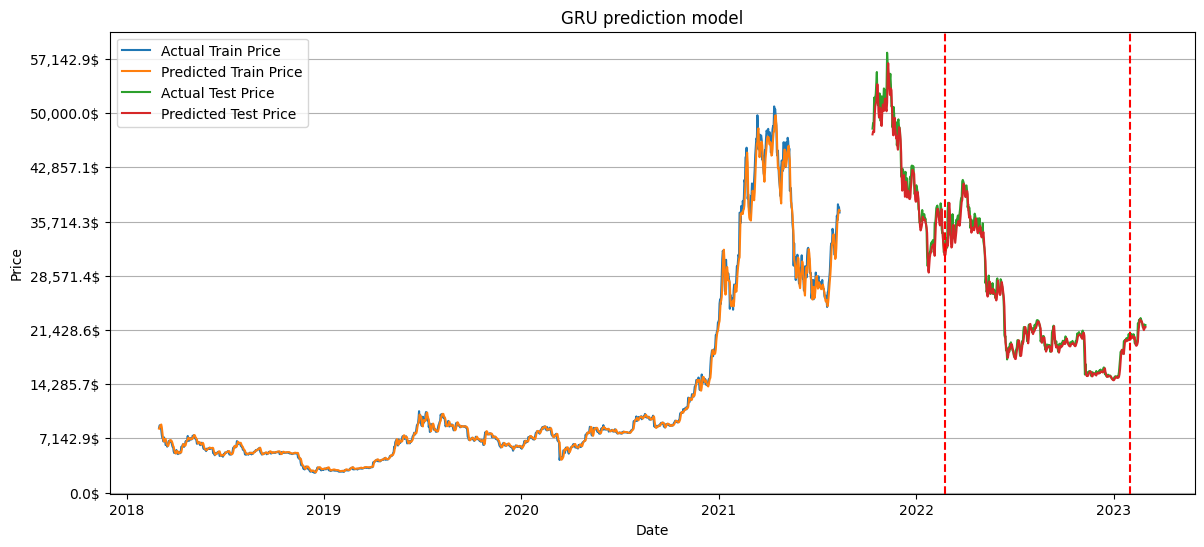

In [22]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# train 데이터 예측 결과 시각화
plt.figure(figsize=(14, 6))

# y_train의 X축 데이터는 train_data 범위 내에서 look_back을 제외한 기간
plt.plot(df[look_back : len(train_data)].index, y_train, label='Actual Train Price')  # len(train_data) : 1789 , len(y_train): 1759
plt.plot(df[look_back : len(train_data)].index, train_predict, label='Predicted Train Price')  # len(train_predict) : 1759

# y_test의 X축 데이터는 test_data 범위 내에서 look_back을 제외한 기간
plt.plot(df[len(train_data) + look_back : len(df)].index, y_test, label='Actual Test Price') # len(df) : 2557
plt.plot(df[len(train_data) + look_back : len(df)].index, test_predict, label='Predicted Test Price')

# 2023년 2월 1일에 빨간색 세로축을 추가합니다. 미국이 기준금리 인상(4.5% -> 4.75%)
target_date = datetime.datetime(2023,2,1)
plt.axvline(x=target_date, color='red', linestyle='--')

# 2022년 2월 24일에 빨간색 세로축을 추가합니다. (우크라이나 전쟁)
tar_date = datetime.datetime(2022, 2, 24)
plt.axvline(x=tar_date, color='red', linestyle='--')
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{round(int(x)/1400,1):,}$')) # y축 달러로 설정
plt.grid(True, axis='y') # 그리드 설정

# 범례를 표시하여 각 선이 무엇을 의미하는지 보여줍니다.
plt.legend()
plt.title("GRU prediction model")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [39]:
# 모델 정확도 판별
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mae_train= mean_absolute_error(y_train, train_predict)
mae_test= mean_absolute_error(y_test, test_predict)

mse_train= mean_squared_error(y_train, train_predict)
mse_test= mean_squared_error(y_test, test_predict)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

train_r2_score = r2_score(y_train, train_predict)
test_r2_score = r2_score(y_test, test_predict)

print(f"mae_train Score: {mae_train:.3f}")
print(f"mae_test Score: {mae_test:.3f}")

print(f"mse_train Score: {mse_train:.3f}")
print(f"mse_test Score: {mse_test:.3f}")

print(f"rmse_train Score: {rmse_train:.3f}")
print(f"rmse_testScore: {rmse_test:.3f}")

print(f"Train R2 Score: {train_r2_score:.3f}")
print(f"Test R2 Score: {test_r2_score:.3f}")

# mae_train Score: 578629.945
# mae_test Score: 1136128.407
# mse_train Score: 1246054783299.394
# mse_test Score: 2766728317737.810
# rmse_train Score: 1116268.240
# rmse_testScore: 1663348.526
# Train R2 Score: 0.995
# Test R2 Score: 0.989

mae_train Score: 589221.529
mae_test Score: 922435.498
mse_train Score: 1031082479376.108
mse_test Score: 1914594373543.391
rmse_train Score: 1015422.316
rmse_testScore: 1383688.684
Train R2 Score: 0.996
Test R2 Score: 0.992


## 뉴스 크롤링후 긍정인 말 이있으면 1, 부정인말이있으면 0 으로 라벨링

## 크롤링
## https://wikidocs.net/85739
## https://www.inflearn.com/course/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%ED%81%AC%EB%A1%A4%EB%A7%81-%EA%B8%B0%EC%B4%88/dashboard

In [ ]:
pip install pygooglenews

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.4 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6046 sha256=a4a15fff038861a66472817c6b1b274d126348faecce2c9543ea58c4fe2b6109
  Stored in directory: /root/.cache/pip/wheels/03/f5/1a/23761066dac1d0e8e683e5fdb27e12de53209d05a4a37e6246
Successfully built sgmllib3k
